# WIP

--------------------------------------
WARNING: This notebook is under construction

-------------------------------------

## Libraries

In [ ]:
!wget -O resized_images.zip --no-check-certificate 'https://drive.google.com/uc?export=download&id=1RpZ8sjO9XiAZ0h-IK85RnSmI0qj5BNGR'

--2023-10-13 21:16:32--  https://drive.google.com/uc?export=download&id=1RpZ8sjO9XiAZ0h-IK85RnSmI0qj5BNGR
Resolving drive.google.com (drive.google.com)... 173.194.69.113, 173.194.69.100, 173.194.69.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.69.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b5cql8t6t23lf237oj1bilm48tj22t9u/1697231775000/01718826444535522071/*/1RpZ8sjO9XiAZ0h-IK85RnSmI0qj5BNGR?e=download&uuid=94c16449-3f9b-4ade-bdeb-39d0e0b5dfe8 [following]
--2023-10-13 21:17:02--  https://doc-0o-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b5cql8t6t23lf237oj1bilm48tj22t9u/1697231775000/01718826444535522071/*/1RpZ8sjO9XiAZ0h-IK85RnSmI0qj5BNGR?e=download&uuid=94c16449-3f9b-4ade-bdeb-39d0e0b5dfe8
Resolving doc-0o-c8-docs.googleusercontent.com (doc-0o-c8-docs.googleusercontent.com)... 108.177.119.132, 2a00

In [ ]:
!unzip resized_images.zip

Archive:  resized_images.zip
   creating: resized_images/akiec/
  inflating: resized_images/akiec/ISIC_0024329.jpg  
  inflating: resized_images/akiec/ISIC_0024372.jpg  
  inflating: resized_images/akiec/ISIC_0024418.jpg  
  inflating: resized_images/akiec/ISIC_0024450.jpg  
  inflating: resized_images/akiec/ISIC_0024463.jpg  
  inflating: resized_images/akiec/ISIC_0024468.jpg  
  inflating: resized_images/akiec/ISIC_0024470.jpg  
  inflating: resized_images/akiec/ISIC_0024511.jpg  
  inflating: resized_images/akiec/ISIC_0024517.jpg  
  inflating: resized_images/akiec/ISIC_0024522.jpg  
  inflating: resized_images/akiec/ISIC_0024539.jpg  
  inflating: resized_images/akiec/ISIC_0024562.jpg  
  inflating: resized_images/akiec/ISIC_0024575.jpg  
  inflating: resized_images/akiec/ISIC_0024579.jpg  
  inflating: resized_images/akiec/ISIC_0024646.jpg  
  inflating: resized_images/akiec/ISIC_0024654.jpg  
  inflating: resized_images/akiec/ISIC_0024707.jpg  
  inflating: resized_images/akiec/I

In [ ]:
import torch
import torch.nn as nn
import random
import numpy as np
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

## Seed

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## Hyperparameters

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate_gen = 0.0005
learning_rate_disc = 0.0001
num_epochs = 100
latent_dim = 100
noise_multiplier = 10
num_steps_gen = 1
img_shape = (3, 64, 64)

## Dataloader

In [ ]:
from glob import glob
import shutil

folders = glob("resized_images/*")
class_threshold = 4000 # Only classes with more than X will be selected
for folder in folders:
    num_images = len(glob(f"{folder}/*.jpg"))
    if num_images < class_threshold:
        shutil.rmtree(folder)

num_classes = len(glob("resized_images/*"))

In [ ]:
# Specify the root directory where the folders are located
data_dir = 'resized_images'

# Normalize to [-1, 1]
rotation_degree = 15
data_transforms = transforms.Compose([
    # transforms.RandomRotation(rotation_degree),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = ImageFolder(root=data_dir, transform=data_transforms)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create training and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, num_classes, latent_dim, use_conv_layers: bool = False):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, latent_dim)

        if use_conv_layers:
            print("Using convolutional layers")
            self.get_conv_model()
        else:
            print("Using dense layers")
            self.get_mlp_model()

    def get_mlp_model(self):
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # self.PrintShape(),

            nn.Linear(1024, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(0.2, inplace=True),
            # self.PrintShape(),

            nn.Linear(4096, 12288, bias=False),
            nn.BatchNorm1d(12288),
            nn.Tanh(),
            # self.PrintShape(),
            nn.Unflatten(1, (3, 64, 64))
        )

    def get_conv_model(self):
        self.model = nn.Sequential(
            # self.PrintShape(),
            nn.Linear(latent_dim * 2, 1024 * 4 * 4, bias=False),
            nn.Unflatten(1, (1024, 4, 4)),
            nn.BatchNorm2d(1024),
            # self.PrintShape(),

            nn.ConvTranspose2d(1024, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # self.PrintShape(),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # self.PrintShape(),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # self.PrintShape(),

            ## 64 x 64
            nn.ConvTranspose2d(128, 3, 12, 2, 1, bias=False),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            # self.PrintShape(),
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and noise to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        gen_input = gen_input.view(gen_input.size(0), gen_input.size(1))
        img = self.model(gen_input)
        return img

    class PrintShape(nn.Module):
        def forward(self, x):
            print(x.shape)
            return x

In [ ]:
fake_generator = Generator(num_classes=num_classes, latent_dim=latent_dim, use_conv_layers=True)
noise = torch.randn(5, latent_dim)
fake_img = fake_generator(noise, torch.tensor([0]*5))
fake_img.shape

Using convolutional layers


torch.Size([5, 3, 64, 64])

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()

        self.img_shape = img_shape

        self.label_embedding = nn.Embedding(num_classes, img_shape[0] * img_shape[1] * img_shape[2])

        self.get_conv_layers()

    def get_conv_layers(self):
        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 5, 5, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, img):
        # Concatenate label embedding with image
        validity = self.model(img)
        return validity.view(-1, 1).squeeze(1)

In [ ]:
# Print number of parameters
generator = Generator(num_classes, latent_dim, use_conv_layers=True)
discriminator = Discriminator(num_classes, img_shape)
print('Number of parameters in generator: {}'.format(sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print('Number of parameters in discriminator: {}'.format(sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))


Using convolutional layers
Number of parameters in generator: 14346090
Number of parameters in discriminator: 1605120


## Losses

In [ ]:
# Loss
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()

## Create Instances

In [ ]:
generator = Generator(latent_dim=latent_dim, num_classes=num_classes, use_conv_layers=True)
discriminator = Discriminator(img_shape=img_shape, num_classes=num_classes)

Using convolutional layers


In [ ]:
# GPU availability
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [ ]:
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_gen, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_disc, betas=(0.5, 0.999))

# # Decay LR by a factor of 0.9 every 500 epochs
# scheduler_G = StepLR(optimizer_G, step_size=500, gamma=0.9)
# scheduler_D = StepLR(optimizer_D, step_size=500, gamma=0.9)

## Training

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 | Generator loss: 0.2585935074492313, Discriminator loss: 0.293251798443851
Disc Accuracy: 0.4980425055928412
Epoch: 2, Step: 100


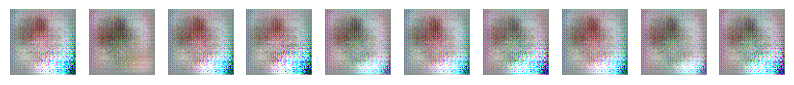

Epoch 2 | Generator loss: 0.29763454845496673, Discriminator loss: 0.26295353401274907
Disc Accuracy: 0.535048471290082
Epoch: 3, Step: 200


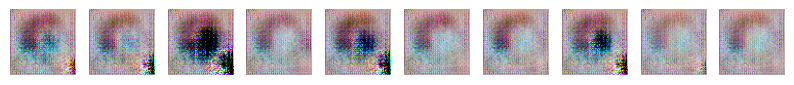

Epoch 3 | Generator loss: 0.3599912681605756, Discriminator loss: 0.22178410120781453
Disc Accuracy: 0.7837434750186428
Epoch: 4, Step: 300


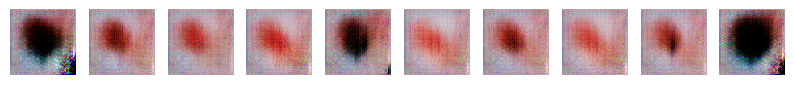

Epoch 4 | Generator loss: 0.41782145036545226, Discriminator loss: 0.18911256044105226
Disc Accuracy: 0.8849739000745712
Epoch: 5, Step: 400


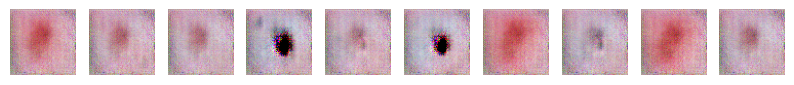

Epoch 5 | Generator loss: 0.45864035757369404, Discriminator loss: 0.17212963027968292
Disc Accuracy: 0.8508575689783744
Epoch: 6, Step: 500


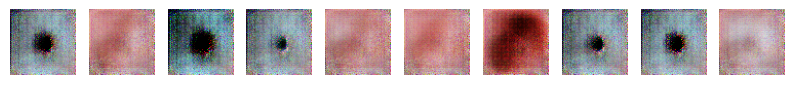

Epoch 6 | Generator loss: 0.48227573516279726, Discriminator loss: 0.16223389902595609
Disc Accuracy: 0.8375279642058165
Epoch 7 | Generator loss: 0.4973042260350178, Discriminator loss: 0.1571659773436128
Disc Accuracy: 0.7946495152870992
Epoch: 8, Step: 600


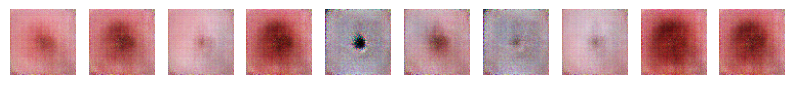

Epoch 8 | Generator loss: 0.5043150807094727, Discriminator loss: 0.15539249310053752
Disc Accuracy: 0.8090044742729307
Epoch: 9, Step: 700


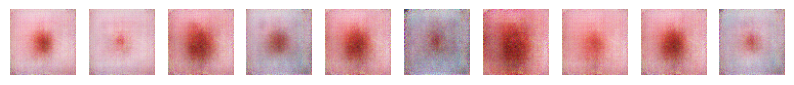

Epoch 9 | Generator loss: 0.5051051594579355, Discriminator loss: 0.157930774250802
Disc Accuracy: 0.7201715137956749
Epoch: 10, Step: 800


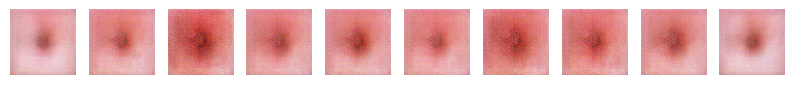

Epoch 10 | Generator loss: 0.5010784861947676, Discriminator loss: 0.1601501562466313
Disc Accuracy: 0.7135533184190902
Epoch: 11, Step: 900


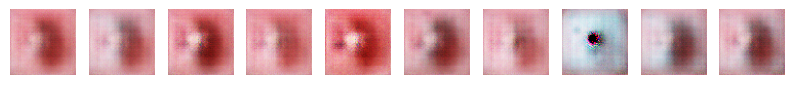

Epoch 11 | Generator loss: 0.4954176540431079, Discriminator loss: 0.1634671220291825
Disc Accuracy: 0.6935123042505593
Epoch: 12, Step: 1000


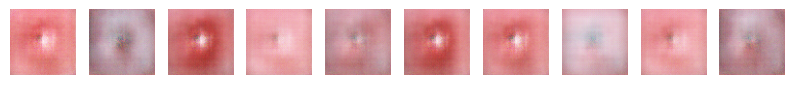

Epoch 12 | Generator loss: 0.48933995889161624, Discriminator loss: 0.1660057029821762
Disc Accuracy: 0.7174683072334079
Epoch 13 | Generator loss: 0.4839697313813097, Discriminator loss: 0.16808364225548075
Disc Accuracy: 0.6957494407158836
Epoch: 14, Step: 1100


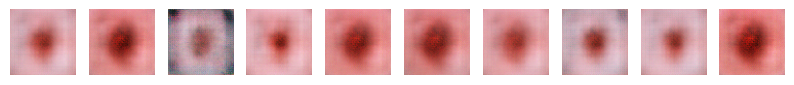

Epoch 14 | Generator loss: 0.4794907616914668, Discriminator loss: 0.17071046646396143
Disc Accuracy: 0.6560402684563759
Epoch: 15, Step: 1200


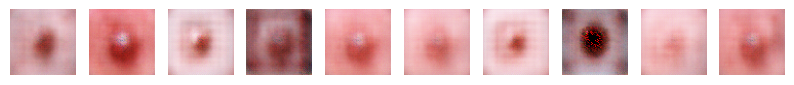

Epoch 15 | Generator loss: 0.4748425133870028, Discriminator loss: 0.17233181522848706
Disc Accuracy: 0.6913683818046235
Epoch: 16, Step: 1300


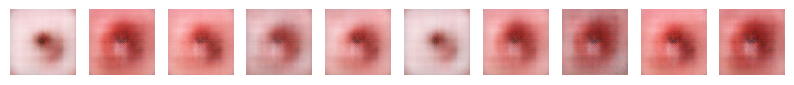

Epoch 16 | Generator loss: 0.4714937436639004, Discriminator loss: 0.17362372935652579
Disc Accuracy: 0.6841909023117076
Epoch: 17, Step: 1400


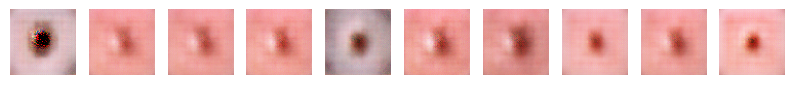

Epoch 17 | Generator loss: 0.46973455678938997, Discriminator loss: 0.17345435957356514
Disc Accuracy: 0.7578299776286354
Epoch: 18, Step: 1500


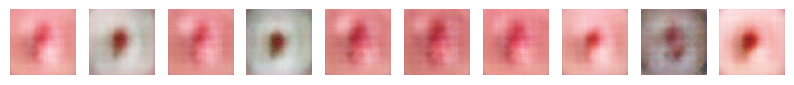

Epoch 18 | Generator loss: 0.4686675980879935, Discriminator loss: 0.1731365615312286
Disc Accuracy: 0.7523303504847129
Epoch 19 | Generator loss: 0.4698493778533454, Discriminator loss: 0.17239166370810086
Disc Accuracy: 0.7830909768829232
Epoch: 20, Step: 1600


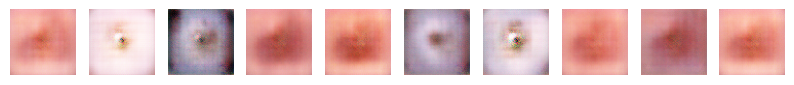

Epoch 20 | Generator loss: 0.4709621806143938, Discriminator loss: 0.17337465397015747
Disc Accuracy: 0.7309843400447428
Epoch: 21, Step: 1700


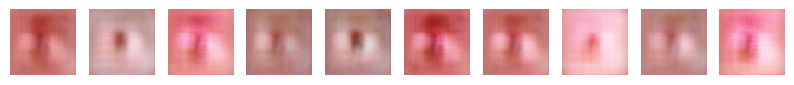

Epoch 21 | Generator loss: 0.4716680337816937, Discriminator loss: 0.1736365265187611
Disc Accuracy: 0.7377889634601044
Epoch: 22, Step: 1800


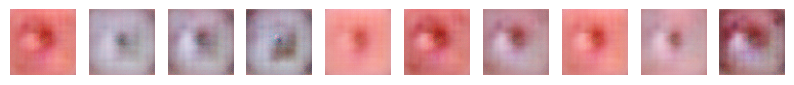

Epoch 22 | Generator loss: 0.47030555120557427, Discriminator loss: 0.17387466272036847
Disc Accuracy: 0.7451528709917972
Epoch: 23, Step: 1900


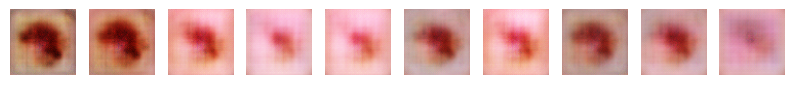

Epoch 23 | Generator loss: 0.46972313633417095, Discriminator loss: 0.17361987409264806
Disc Accuracy: 0.7549403430275914
Epoch: 24, Step: 2000


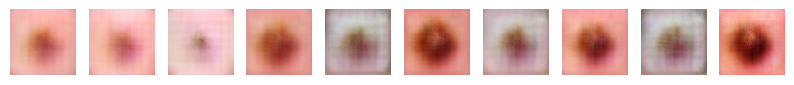

Epoch 24 | Generator loss: 0.46735298695501926, Discriminator loss: 0.1741655027606554
Disc Accuracy: 0.7115958240119314
Epoch: 25, Step: 2100


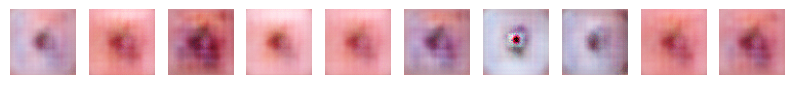

Epoch 25 | Generator loss: 0.465351205997036, Discriminator loss: 0.17417897930546175
Disc Accuracy: 0.7602535421327368
Epoch 26 | Generator loss: 0.46282731613076905, Discriminator loss: 0.17454117378339362
Disc Accuracy: 0.7257643549589858
Epoch: 27, Step: 2200


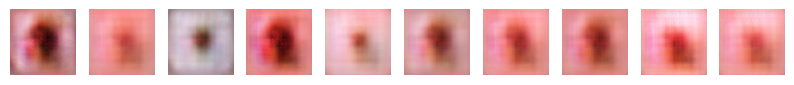

Epoch 27 | Generator loss: 0.4586341781494482, Discriminator loss: 0.17572400715067404
Disc Accuracy: 0.677199850857569
Epoch: 28, Step: 2300


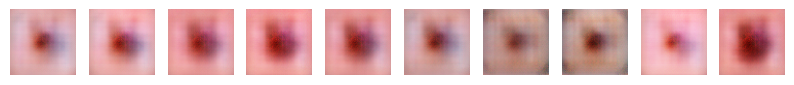

Epoch 28 | Generator loss: 0.4545327564703418, Discriminator loss: 0.17665575373819617
Disc Accuracy: 0.6953765846383296
Epoch: 29, Step: 2400


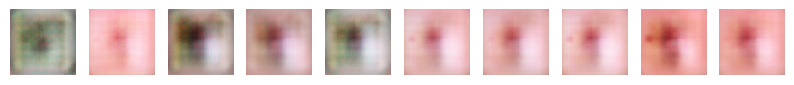

Epoch 29 | Generator loss: 0.45053424683154053, Discriminator loss: 0.1776918245942832
Disc Accuracy: 0.6799962714392245
Epoch: 30, Step: 2500


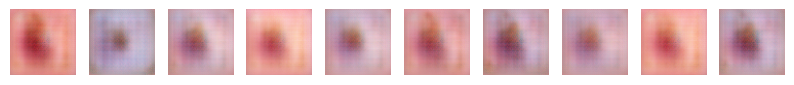

Epoch 30 | Generator loss: 0.44715056292258115, Discriminator loss: 0.17853802533391566
Disc Accuracy: 0.7069351230425056
Epoch: 31, Step: 2600


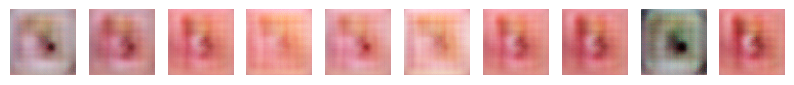

Epoch 31 | Generator loss: 0.4434475939716935, Discriminator loss: 0.17983426672468011
Disc Accuracy: 0.6473713646532439
Epoch 32 | Generator loss: 0.44076229232225506, Discriminator loss: 0.18067197569360446
Disc Accuracy: 0.688944817300522
Epoch: 33, Step: 2700


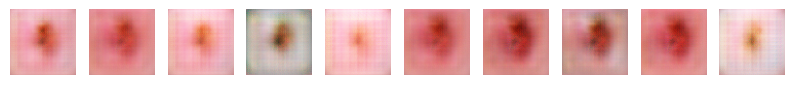

Epoch 33 | Generator loss: 0.438759747774523, Discriminator loss: 0.18104681177037898
Disc Accuracy: 0.6932326621923938
Epoch: 34, Step: 2800


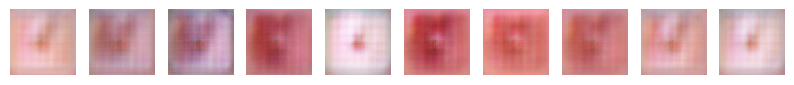

Epoch 34 | Generator loss: 0.43618892271515813, Discriminator loss: 0.1816922632895191
Disc Accuracy: 0.7057233407904548
Epoch: 35, Step: 2900


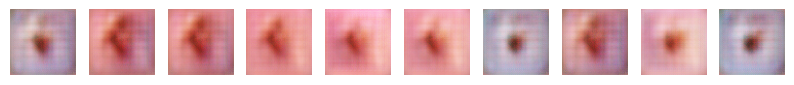

Epoch 35 | Generator loss: 0.434328327399083, Discriminator loss: 0.18224641082200166
Disc Accuracy: 0.6655480984340044
Epoch: 36, Step: 3000


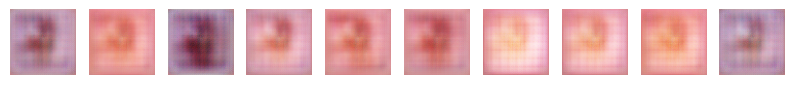

Epoch 36 | Generator loss: 0.4329455135263584, Discriminator loss: 0.18236742395397632
Disc Accuracy: 0.7178411633109619
Epoch: 37, Step: 3100


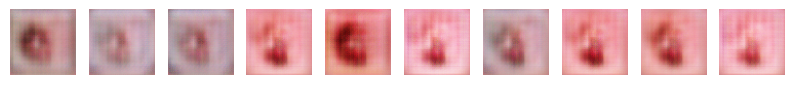

Epoch 37 | Generator loss: 0.43236780063080765, Discriminator loss: 0.1818992892763262
Disc Accuracy: 0.7794556301267711
Epoch 38 | Generator loss: 0.4319647750060102, Discriminator loss: 0.18166207363257153
Disc Accuracy: 0.7806674123788218
Epoch: 39, Step: 3200


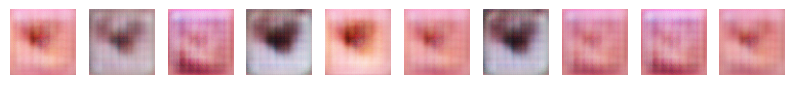

Epoch 39 | Generator loss: 0.4314049224897148, Discriminator loss: 0.18151257801926052
Disc Accuracy: 0.7486017897091722
Epoch: 40, Step: 3300


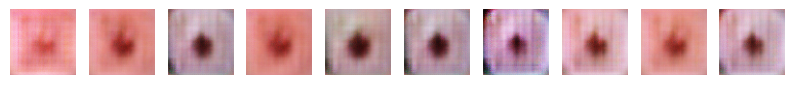

Epoch 40 | Generator loss: 0.4307050506009199, Discriminator loss: 0.18145715348655359
Disc Accuracy: 0.7462714392244594
Epoch: 41, Step: 3400


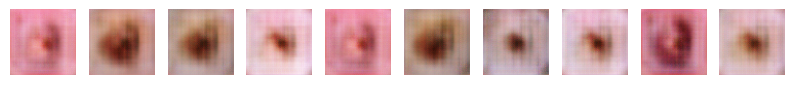

Epoch 41 | Generator loss: 0.4297978682866705, Discriminator loss: 0.18166185042179436
Disc Accuracy: 0.7198918717375093
Epoch: 42, Step: 3500


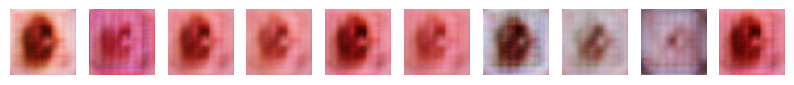

Epoch 42 | Generator loss: 0.4285254804038679, Discriminator loss: 0.18174188748654613
Disc Accuracy: 0.741331096196868
Epoch: 43, Step: 3600


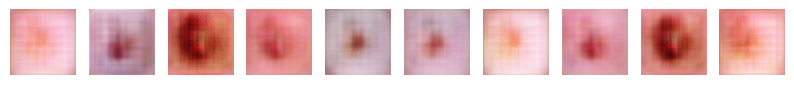

Epoch 43 | Generator loss: 0.4279664652825592, Discriminator loss: 0.18188821881904307
Disc Accuracy: 0.7279082774049217
Epoch 44 | Generator loss: 0.42739896857276966, Discriminator loss: 0.18190411318474534
Disc Accuracy: 0.735365398956003
Epoch: 45, Step: 3700


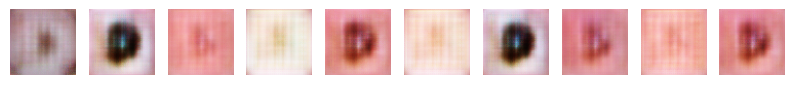

Epoch 45 | Generator loss: 0.4259591559116931, Discriminator loss: 0.1825505566881802
Disc Accuracy: 0.660234899328859
Epoch: 46, Step: 3800


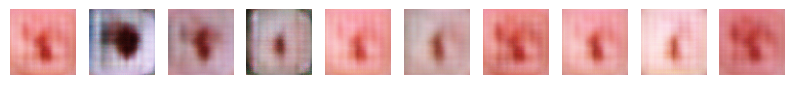

Epoch 46 | Generator loss: 0.424101501979116, Discriminator loss: 0.18330601728174212
Disc Accuracy: 0.6556674123788218
Epoch: 47, Step: 3900


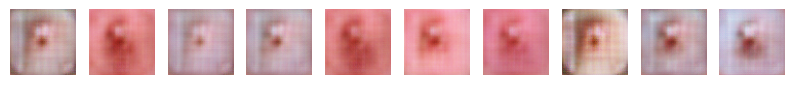

Epoch 47 | Generator loss: 0.42197633610357527, Discriminator loss: 0.18429471942121511
Disc Accuracy: 0.6164243102162565
Epoch: 48, Step: 4000


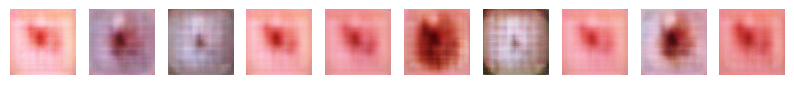

Epoch 48 | Generator loss: 0.41967799008044593, Discriminator loss: 0.18528461262504275
Disc Accuracy: 0.6026286353467561
Epoch: 49, Step: 4100


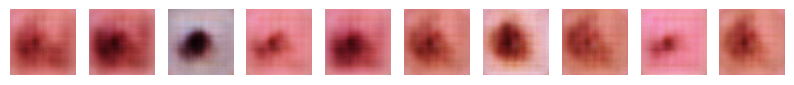

Epoch 49 | Generator loss: 0.41763672952174113, Discriminator loss: 0.1861635272108757
Disc Accuracy: 0.6174496644295302
Epoch: 50, Step: 4200


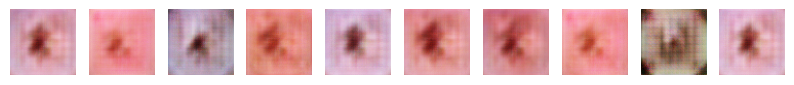

Epoch 50 | Generator loss: 0.41545456303205963, Discriminator loss: 0.1870531547091724
Disc Accuracy: 0.6180089485458613
Epoch 51 | Generator loss: 0.4138100490855126, Discriminator loss: 0.18769470003870925
Disc Accuracy: 0.6480238627889635
Epoch: 52, Step: 4300


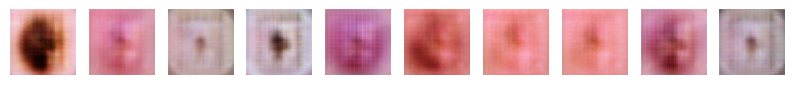

Epoch 52 | Generator loss: 0.412769593000041, Discriminator loss: 0.1881239970880748
Disc Accuracy: 0.6706748695003728
Epoch: 53, Step: 4400


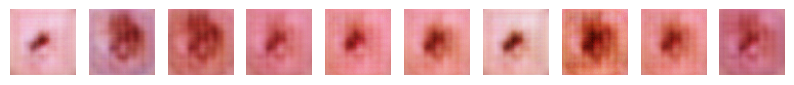

Epoch 53 | Generator loss: 0.41103425935282717, Discriminator loss: 0.1889376254624253
Disc Accuracy: 0.613627889634601
Epoch: 54, Step: 4500


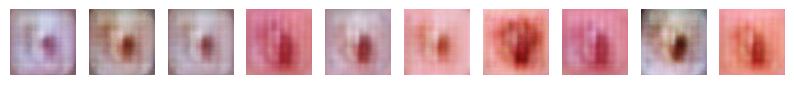

Epoch 54 | Generator loss: 0.4093812240627052, Discriminator loss: 0.18963230568693862
Disc Accuracy: 0.6208053691275168
Epoch: 55, Step: 4600


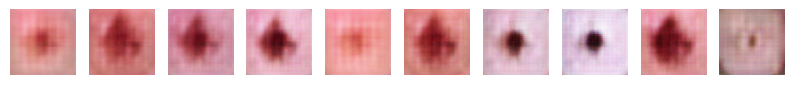

Epoch 55 | Generator loss: 0.4077726346365019, Discriminator loss: 0.19041328407799848
Disc Accuracy: 0.6021625652498136
Epoch: 56, Step: 4700


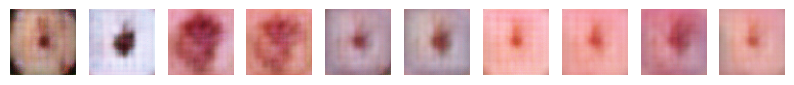

Epoch 56 | Generator loss: 0.40614042627527364, Discriminator loss: 0.19106369685313543
Disc Accuracy: 0.6272371364653244
Epoch 57 | Generator loss: 0.40430222700982926, Discriminator loss: 0.19180625674813526
Disc Accuracy: 0.5933072334079046
Epoch: 58, Step: 4800


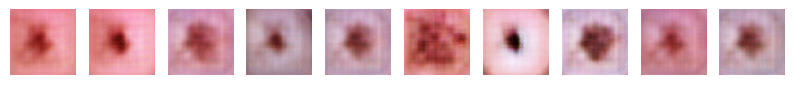

Epoch 58 | Generator loss: 0.40262290830955244, Discriminator loss: 0.19263101959018394
Disc Accuracy: 0.5904175988068605
Epoch: 59, Step: 4900


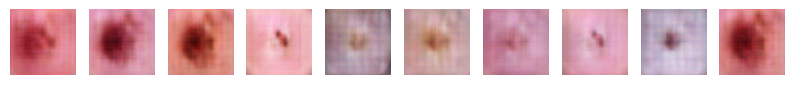

Epoch 59 | Generator loss: 0.4011989110815613, Discriminator loss: 0.19321600959506233
Disc Accuracy: 0.6231357196122297
Epoch: 60, Step: 5000


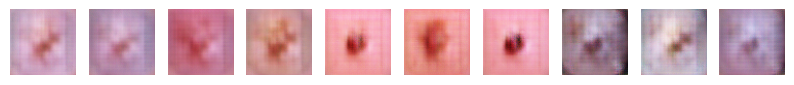

Epoch 60 | Generator loss: 0.3997927941382855, Discriminator loss: 0.19385431929720595
Disc Accuracy: 0.6108314690529456
Epoch: 61, Step: 5100


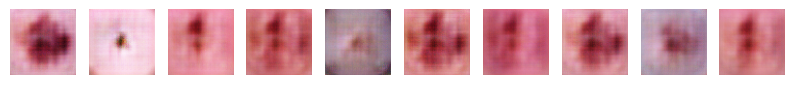

Epoch 61 | Generator loss: 0.39826870939698344, Discriminator loss: 0.19452858495996403
Disc Accuracy: 0.5977815063385533
Epoch: 62, Step: 5200


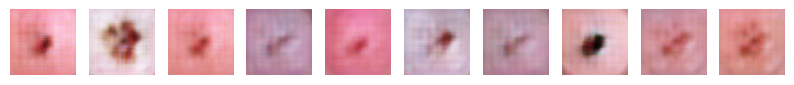

Epoch 62 | Generator loss: 0.39690596100163594, Discriminator loss: 0.19513183267259207
Disc Accuracy: 0.5935868754660701
Epoch 63 | Generator loss: 0.39548153348011195, Discriminator loss: 0.19575346374633643
Disc Accuracy: 0.6009507829977628
Epoch: 64, Step: 5300


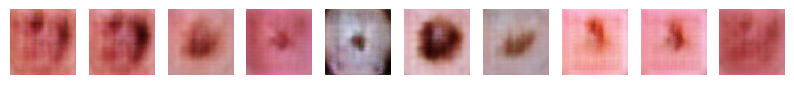

Epoch 64 | Generator loss: 0.3942727065532381, Discriminator loss: 0.19621454278967576
Disc Accuracy: 0.627703206562267
Epoch: 65, Step: 5400


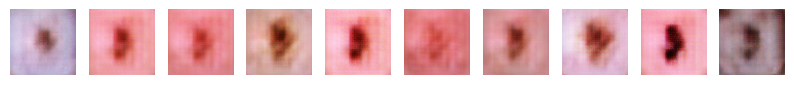

Epoch 65 | Generator loss: 0.39319937562940116, Discriminator loss: 0.19677441449999644
Disc Accuracy: 0.6153057419835943
Epoch: 66, Step: 5500


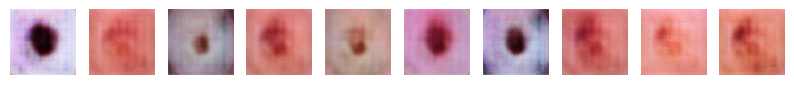

Epoch 66 | Generator loss: 0.39228853804684577, Discriminator loss: 0.19711326799841938
Disc Accuracy: 0.6434563758389261
Epoch: 67, Step: 5600


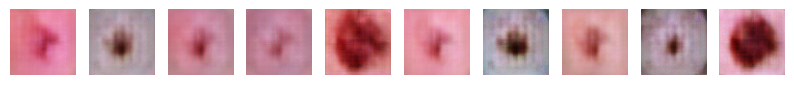

Epoch 67 | Generator loss: 0.39161044060953915, Discriminator loss: 0.19738720244395083
Disc Accuracy: 0.656972408650261
Epoch: 68, Step: 5700


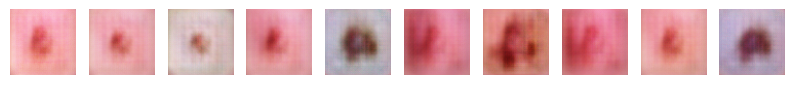

Epoch 68 | Generator loss: 0.3905957200074815, Discriminator loss: 0.19776300574928074
Disc Accuracy: 0.6294742729306487
Epoch 69 | Generator loss: 0.39000635218651986, Discriminator loss: 0.19797779237427296
Disc Accuracy: 0.6589299030574198
Epoch: 70, Step: 5800


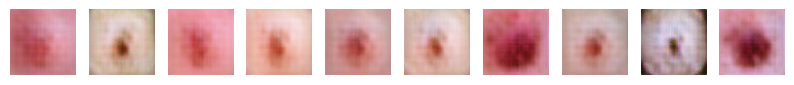

Epoch 70 | Generator loss: 0.3895387111523911, Discriminator loss: 0.19819507535046513
Disc Accuracy: 0.6609806114839671
Epoch: 71, Step: 5900


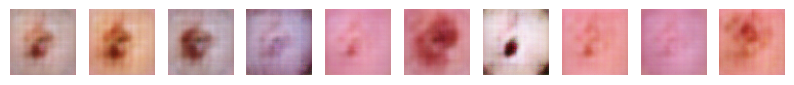

Epoch 71 | Generator loss: 0.38917122343669086, Discriminator loss: 0.19832598647892244
Disc Accuracy: 0.6803691275167785
Epoch: 72, Step: 6000


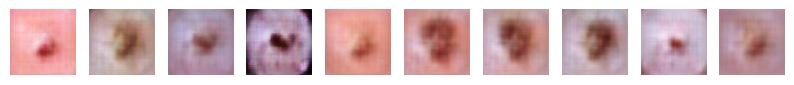

Epoch 72 | Generator loss: 0.3887185841188526, Discriminator loss: 0.19853584955861575
Disc Accuracy: 0.6574384787472036
Epoch: 73, Step: 6100


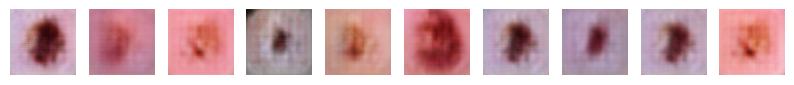

Epoch 73 | Generator loss: 0.38789751677765083, Discriminator loss: 0.19886588389710058
Disc Accuracy: 0.642710663683818
Epoch: 74, Step: 6200


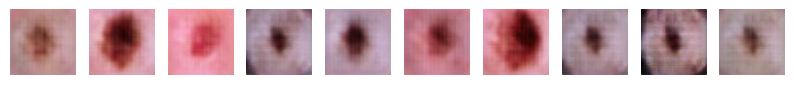

Epoch 74 | Generator loss: 0.38712914491695877, Discriminator loss: 0.19918928803016636
Disc Accuracy: 0.6327367636092468
Epoch: 75, Step: 6300


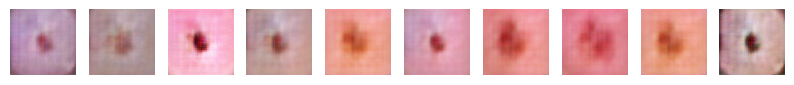

Epoch 75 | Generator loss: 0.3861607823072238, Discriminator loss: 0.19965326494079025
Disc Accuracy: 0.6059843400447428
Epoch 76 | Generator loss: 0.3852423226828004, Discriminator loss: 0.20004362944089912
Disc Accuracy: 0.6140007457121551
Epoch: 77, Step: 6400


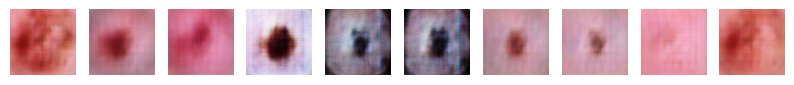

Epoch 77 | Generator loss: 0.3844135362199486, Discriminator loss: 0.20038248082892435
Disc Accuracy: 0.619220730797912
Epoch: 78, Step: 6500


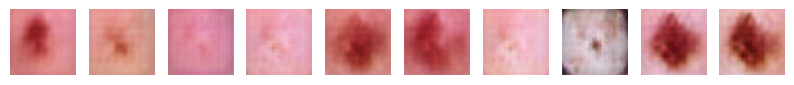

Epoch 78 | Generator loss: 0.3834987932712241, Discriminator loss: 0.200760643225634
Disc Accuracy: 0.6208053691275168
Epoch: 79, Step: 6600


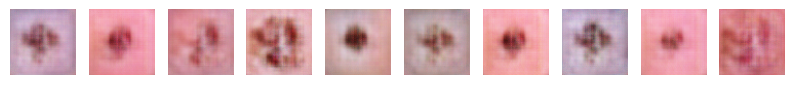

Epoch 79 | Generator loss: 0.382578752522953, Discriminator loss: 0.20117823012434777
Disc Accuracy: 0.5941461595824012
Epoch: 80, Step: 6700


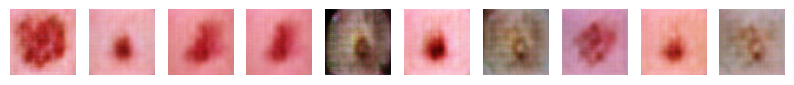

Epoch 80 | Generator loss: 0.3816044151550852, Discriminator loss: 0.20159762193853523
Disc Accuracy: 0.6008575689783744
Epoch: 81, Step: 6800


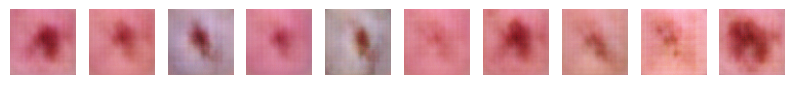

Epoch 81 | Generator loss: 0.38073422125646617, Discriminator loss: 0.20197259695972725
Disc Accuracy: 0.607475764354959
Epoch 82 | Generator loss: 0.3800105813287797, Discriminator loss: 0.2022409146507222
Disc Accuracy: 0.6371178225205071
Epoch: 83, Step: 6900


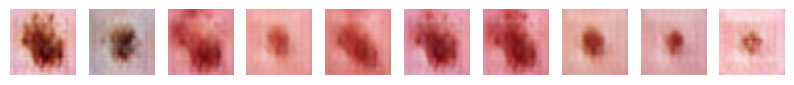

Epoch 83 | Generator loss: 0.37948666601777087, Discriminator loss: 0.2024776773808852
Disc Accuracy: 0.6418717375093214
Epoch: 84, Step: 7000


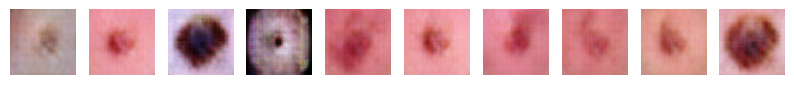

Epoch 84 | Generator loss: 0.37872344306666167, Discriminator loss: 0.20304441565669895
Disc Accuracy: 0.5915361670395227
Epoch: 85, Step: 7100


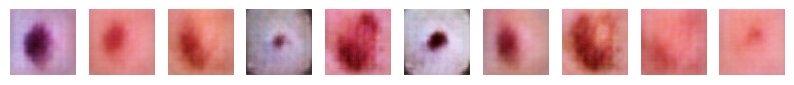

Epoch 85 | Generator loss: 0.37785242560433085, Discriminator loss: 0.20343066136527505
Disc Accuracy: 0.6042132736763609
Epoch: 86, Step: 7200


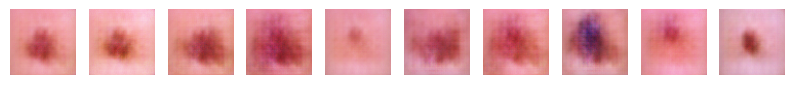

Epoch 86 | Generator loss: 0.3769866221451978, Discriminator loss: 0.20387586293683274
Disc Accuracy: 0.575503355704698
Epoch: 87, Step: 7300


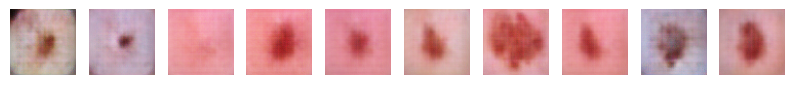

Epoch 87 | Generator loss: 0.3759811302371345, Discriminator loss: 0.20429708411280917
Disc Accuracy: 0.5789522744220731
Epoch 88 | Generator loss: 0.3752992561529113, Discriminator loss: 0.20455024149132794
Disc Accuracy: 0.62751677852349
Epoch: 89, Step: 7400


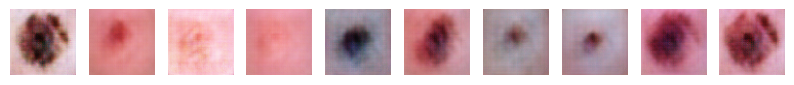

Epoch 89 | Generator loss: 0.3744418088331397, Discriminator loss: 0.2049521986435483
Disc Accuracy: 0.5833333333333334
Epoch: 90, Step: 7500


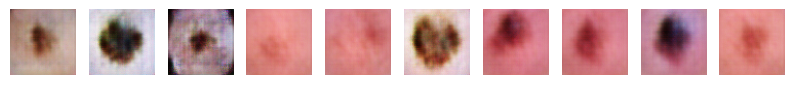

Epoch 90 | Generator loss: 0.37432187016192264, Discriminator loss: 0.20503325613742823
Disc Accuracy: 0.6638702460850112
Epoch: 91, Step: 7600


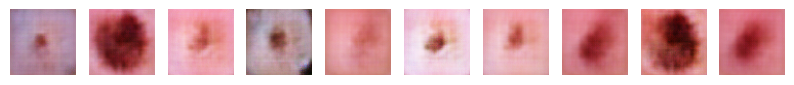

Epoch 91 | Generator loss: 0.3742412708023873, Discriminator loss: 0.2050095246361558
Disc Accuracy: 0.7026472781506339
Epoch: 92, Step: 7700


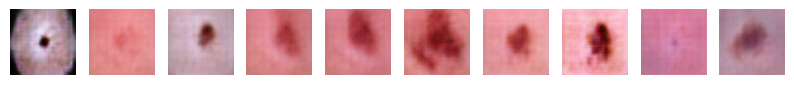

Epoch 92 | Generator loss: 0.3735971523229612, Discriminator loss: 0.20526139286908804
Disc Accuracy: 0.6229492915734527
Epoch: 93, Step: 7800


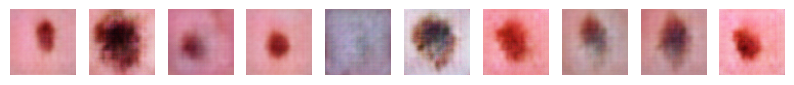

Epoch 93 | Generator loss: 0.3727414030019605, Discriminator loss: 0.2056323836774065
Disc Accuracy: 0.5815622669649515
Epoch 94 | Generator loss: 0.3718879440896191, Discriminator loss: 0.20600131894707144
Disc Accuracy: 0.5798844146159582
Epoch: 95, Step: 7900


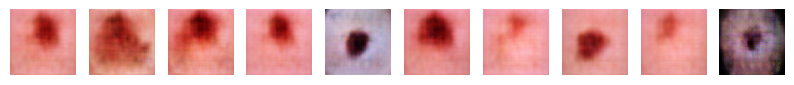

Epoch 95 | Generator loss: 0.3710577983885915, Discriminator loss: 0.20642365643259764
Disc Accuracy: 0.5568605518269948
Epoch: 96, Step: 8000


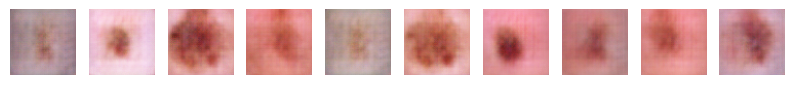

Epoch 96 | Generator loss: 0.3702980480332963, Discriminator loss: 0.20676363258560684
Disc Accuracy: 0.5855704697986577
Epoch: 97, Step: 8100


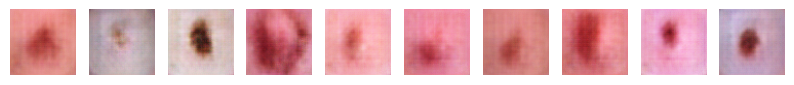

Epoch 97 | Generator loss: 0.3694542174364811, Discriminator loss: 0.20712727260289857
Disc Accuracy: 0.5732662192393736
Epoch: 98, Step: 8200


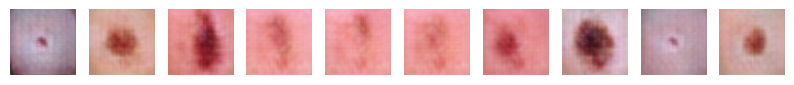

Epoch 98 | Generator loss: 0.3686522894038998, Discriminator loss: 0.2074741654967359
Disc Accuracy: 0.5833333333333334
Epoch: 99, Step: 8300


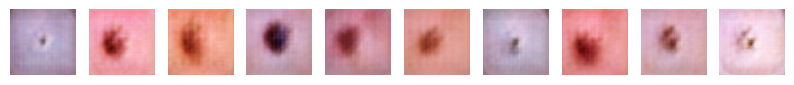

Epoch 99 | Generator loss: 0.36794829110926514, Discriminator loss: 0.20778300096502617
Disc Accuracy: 0.5815622669649515
Epoch: 100, Step: 8400


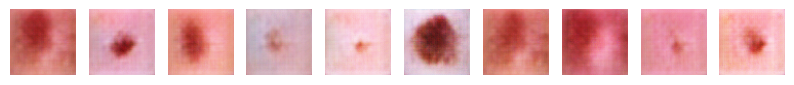

Epoch 100 | Generator loss: 0.3673082937655549, Discriminator loss: 0.20805596321577294
Disc Accuracy: 0.5936800894854586


In [ ]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Training loop
device = "cuda" if torch.cuda.is_available() else "cpu"

total_steps = 0
disc_loss = []
gen_loss = []

generator.train()
discriminator.train()
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    correct_preds = 0
    total_preds = 0
    for i, (imgs, labels) in enumerate(train_dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        valid = torch.full((imgs.size(0), 1), 1.0, device=imgs.device).squeeze()
        fake = torch.full((imgs.size(0), 1), 0.0, device=imgs.device).squeeze()

        # Training the generator twice
        for _ in range(num_steps_gen):
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()

            # Generate a batch of images
            noise = noise_multiplier * torch.randn(imgs.size(0), latent_dim).to(imgs.device)
            gen_labels = torch.randint(0, num_classes, (imgs.size(0),)).to(imgs.device).squeeze()
            generated_imgs = generator(noise, gen_labels)

            # Loss measures generator's ability to fool the discriminator
            validity = discriminator(generated_imgs, gen_labels)
            correct_preds += (validity < 0.5).sum().item()
            total_preds += validity.size(0)
            g_loss = adversarial_loss(validity, valid)

            g_loss.backward()
            optimizer_G.step()
            # scheduler_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(imgs, labels)
        correct_preds += (validity_real > 0.5).sum().item()
        total_preds += validity_real.size(0)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(generated_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        # scheduler_D.step()

        total_steps += 1

        if total_steps % 100 == 0:
            # Generate image
            generator.eval()
            num_images = 10
            noise_sample = noise_multiplier * torch.randn(num_images, latent_dim).to(device)
            gen_labels_sample = torch.randint(0, num_classes, (num_images,)).to(device)
            generated_imgs = generator(noise_sample, gen_labels_sample)

            # Show images
            plt.figure(figsize=(num_images,num_images))
            print(f"Epoch: {epoch+1}, Step: {total_steps}")
            for k in range(num_images):
                img = generated_imgs[k].cpu().detach().numpy()
                img = np.transpose(img, (1, 2, 0))
                img = (img + 1) / 2
                plt.subplot(1, num_images, k+1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()
            generator.train()

        disc_loss.append(d_loss.item())
        gen_loss.append(g_loss.item())

    print(f"Epoch {epoch+1} | Generator loss: {sum(gen_loss)/len(gen_loss)}, Discriminator loss: {sum(disc_loss)/len(disc_loss)}")
    print(f"Disc Accuracy: {correct_preds/total_preds}")


Class: 0


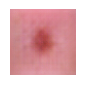

In [ ]:
# For each class generates 10 images
generator.eval()
dataset_to_sample = list(val_dataset)
for i in range(num_classes):
    noise = torch.randn(10, latent_dim).to(device)
    gen_labels = torch.full((10, 1), i, device=device).squeeze()
    generated_imgs = generator(noise, gen_labels)
    plt.figure(figsize=(10,10))
    print(f"Class: {i}")
    for k in range(num_classes):
        img = generated_imgs[k].cpu().detach().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = (img + 1) / 2
        plt.subplot(1, 10, k+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()